# Introduction

In 2003, I began a practice of journaling - essentially writing down my thoughts, plans, fears, and introspections into a simple text file. It's been sporadically updated (at least once a month) until the present day. Journaling is an invaluable tool to better understand one's own mind: to analyze decision making patterns, identify trends, and find purpose in this confusing world. 

Over the years, I've conducted plenty of informal, manual deep-dives into my journal. For example, when recovering from an injury, I used my journal to identify triggers that caused aggravation and plotted those over time to better understand how my recovery process was being shaped by my behavior. What if there was a way to do this analysis programmatically? Luckily, there is - it's called Natural Language Processing (NLP) - and there are plenty of libraries that allow us to parse and analyze vast amounts of text.

We will use TextBlob, a popular python NLP library, to address the following:

* Summary statistics: words per year, entries per year, overall words.
* Most common words and combinations of words using word clouds.
* Parts of Speech tagging (Noun, verb, adjective).
* Phrases over the years using popular combinations of words (N-grams).
* Sentiment polarity analysis - how has the tone (positive/negative) changed over time?
* Train our own sentiment analyzer and compare results with the built-in Naive Bayes classifiers

# Summary of Results

* **High level stats:** I've written 631,597 words into 787 total journal entries, spanning 17 years.  On average, I write 44 entries and 35,0000 words per year with 803 words per entry. 
* **Word count per year and entry has not remained constant.**  During periods of life transition (graduating from college, moving abroad) - word count drastically increased.  In 2020, average length per entry decreased drastically due to new daily journal format.  
* **Increase in use of unique words over time**.  The data show a general upward trend of unique word usage as time goes on (1,000 unique words in 2003 vs. 4,000 in 2020).  This could indicate an increase in vocabulary as well as a wider variety of experiences to write about. 
* **Frequency of journal entries by month is relatively constant, with small peaks in the summer months (July/August).**  Possibly there was more vacation or traveling during these times, therefore more new experiences to write about. 

#### Most Common Words by Part of Speech

* *Nouns: time, day, people, life.* Common themes that would appear in a personal journal: essential elements of life. 
* *Verbs: think, want, feel, know, need, know.*  Most are verbs of introspection.
* *Adjectives and Adverbs: good, great, awesome, super, nice.*  I think this reflects my generally positive nature.

#### Sentiment Polarity Analysis 

* *Steady increase in more positive sentiment over time (4x increase in 2020 vs. 2003).* This is a good sign of a general upward trend in positivity of journal entries as time goes on.
* *High variability of polarity in transition years.* For exmaple: graduating college, changing careers, moving abroad.
* *Positive sentiment polarity decreases as year goes on - .175 in January to .125 in December.* We're seeing some very slight seasonality when viewing sentiment polarity by calendar month: slightly more positive sentiments at the start of the year, and moderately decrasing as the year comes to a close.  This logically makes sense: January is the start of the year and a time for resolutions, new beginnings and higher motivation to create change in one's life!  




# Data Cleaning and Processing

The journal lives in Google Docs; each year is represented by an individual Docs file.  The Docs files are exported as '.txt' and then imported into our notebook.  We loop through each file, parsing out the date (using various possible formats) and storing it, along with the journal entry itself, in a pandas DataFrame.

A challenging aspect of this process was to deal with various date formats.  The formatting in my journal was highly variable over time - some examples of possible formats:

* January, 7, 2020
* 1/7/20
* 1/7/2020
* Jan 7th, 2020

This issue was solved with a lot of trial and error using regex pattern matching.  

In [1]:
import os
import pandas as pd
import re
pd.set_option('display.max_colwidth', -1)

#Read contents of journal archive into list for processing
folder='archive/'
list_of_journals=[]
journal_files = os.listdir(folder)
for file in journal_files:
    full_file_path=folder+file
    list_of_journals.append(full_file_path)
    
#Create DataFrame shell to load data as we parse through journal
journal_df = pd.DataFrame(columns=['year', 'date', 'entry'])

#For each file(a single year), read in data.
for full_file_path in list_of_journals:
    journal_list_of_dicts = []
    journal_dict={}
    paragraph_list = []
    previous_date='NONE'
    journal_raw = open(full_file_path)
    
    #parse out specific year from text file for use in dataframe
    year = re.search(r'(\d{4})',full_file_path).group()
    
    #Read in journal line, by line and parse our dates to associate dates with specific entry  
    for paragraph in journal_raw.readlines():
        #Use pattern matching to parse out date, input can be various formats (May 17, 5/17, 5/17/2020, etc)
        pattern = r'(\d+(\/|-){1}\d+(\/|-)?\d{0,4})|((Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s\d{1,2})'
        date_match = re.search(pattern, paragraph, re.IGNORECASE)
        if date_match and len(paragraph)<35: #length to prevent mid paragraph dates from being grabbed
            if len(journal_list_of_dicts)>0: #this is not the first instance of date, therefore we need to save date and list of paragraphs
                journal_dict = {'year':year,
                                'date': previous_date,
                                'entry': paragraph_list}
                journal_list_of_dicts.append(journal_dict)
                #save for use in next loop
                previous_date = date_match.group()
                #re_initialize list of paragraphs, and journal_dict
                paragraph_list = []
                journal_dict = {}
            else:
                if previous_date == 'NONE':
                #continue looping and save date, this is the first instance of saving a date - need to continue loop to graph paragraphs
                    previous_date = date_match.group()
                else:
                    #first instance and need to start list of dicts
                    journal_dict = {'date': previous_date,
                                    'year':year,
                                    'entry': paragraph_list}
                    journal_list_of_dicts.append(journal_dict)
                    previous_date = date_match.group(0)
                    #reset for next date
                    paragraph_list = []
                    journal_dict = {}
        else:
            #paragraph is not a date entry is continuing - must be saved to paragraph list
            paragraph_list.append(paragraph)
    #final entry
    journal_dict = {'date': previous_date,
                    'year':year,
                    'entry': paragraph_list}
    journal_list_of_dicts.append(journal_dict)
    #save to DF and concat to previous
    journal_df = pd.concat([pd.DataFrame(journal_list_of_dicts),journal_df], sort=False)


We now have our data reasonably organized into a DataFrame.  Each row is a single day's entry with multiple paragraphs.  Let's further clean the data by creating functions for the following tasks:
* Remove empty paragraphs
* Word and paragraph count
* Tokenize sentences
* Lemmatized list of words - essentially converting each word into it's base form (went, going = go)
* Standardize date format - it's currently a string field and exists in many different formats

In [2]:
from datetime import datetime, timedelta
import numpy as np
from textblob import TextBlob
from nltk.tokenize import sent_tokenize
from textblob import Word
import contractions
import string

#Remove empty paragraphs
def clean_paragraph(entry):
    cleaned_paragraph_list=[]
    for paragraph in entry:
        if paragraph!='\n':
            cleaned_paragraph_list.append(paragraph)
    return cleaned_paragraph_list
journal_df['entry'] = journal_df['entry'].apply(clean_paragraph)

#Count words and paragraphs
def word_count(entry):
    total_word_count=0
    for paragraph in entry:
        words = len(paragraph.split())
        total_word_count = words + total_word_count
    return total_word_count
journal_df['word_count'] = journal_df['entry'].apply(word_count)
journal_df['paragraph_count'] = journal_df['entry'].apply(lambda x: len(x))

#Standardize date format
def parse_date(row):
    date = row['date']
    if bool(re.match(r'[a-z]', date,  re.IGNORECASE)):
        #contains letters - concatenate to year
        date = date + ', '+ row['year']
        #try various formats
        for fmt in ('%B %d, %Y',
                '%b %d, %Y'):
            try:
                return datetime.strptime(date, fmt)
            except ValueError:
                pass
        return np.nan
    else: 
        for fmt in ('%Y-%m-%d',
                    '%d.%m.%Y',
                    '%m/%d/%Y',
                    '%m-%d-%Y',
                    '%m/%d/%y',
                    '%m-%d-%y'):
            try:
                return datetime.strptime(date, fmt)
            except ValueError:
                pass
        try:
            date = date + '-'+ row['year']
            return datetime.strptime(date, '%m-%d-%Y')
        except ValueError:
            return np.nan
journal_df['datetime'] = journal_df.apply(lambda x: parse_date(x), axis=1)

#NLLKT method: Add Column with paragraphs tokenized into sentences
def sentences_tokenized(entry):
    sent_list =[]
    for paragraph in entry:
        sent_list.append(sent_tokenize(paragraph))
    return sent_list
journal_df['sentences_tokenized'] = journal_df['entry'].apply(sentences_tokenized)

'''
Lemmatization is the process of converting a word to its base form. 
The difference between stemming and lemmatization is, 
lemmatization considers the context and converts the word to its meaningful base form, 
whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.
Source: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#textbloblemmatizer
'''
#identify part of speech in order to pass into lemmatizer for improved context
def lemmatize_with_postag(sentence):
    sent = TextBlob(str.lower(sentence))
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return lemmatized_list

def lemmatize(entry):
    word_list = []
    #lem = WordNetLemmatizer()
    for paragraph in entry:
        #lower case
        paragraph_fixed = str.lower(paragraph)
        #fix contractions
        #see https://medium.com/@lukei_3514/dealing-with-contractions-in-nlp-d6174300876b
        paragraph_fixed = contractions.fix(paragraph_fixed)
        word_list = word_list + lemmatize_with_postag(paragraph_fixed)
    return word_list
journal_df['lemmatized_words'] = journal_df['entry'].apply(lemmatize)

#sort by date and re-index
journal_df = journal_df.sort_values('datetime', ascending=True)
journal_df = journal_df.reset_index().drop(['index'], axis=1)

# Memories

Let's look back on what I wrote about the same day 1 year ago, 5 years ago and fifteen years ago.  What has changed and what has remained constant?

In [242]:
from datetime import datetime
#Define date ranges
now = datetime.utcnow()
one_year_ago = (now -  timedelta(days=365))
five_years_ago = (now -  timedelta(days=(365*5)))                 
fifteen_years_ago = (now -  timedelta(days=(365*15)))
#filter out null datetimes
journal_df_no_null_datetime = journal_df[~journal_df.datetime.isnull()]
#convert datetime to list, match closest, select df
def match_date(datetime_list, date_to_match):
    differences = [abs(date_to_match - each_date) for each_date in datetime_list]
    minimum = min(differences)
    closest_date = datetime_list[differences.index(minimum)]
    return closest_date.strftime('%Y-%m-%d')
    
datetime_list = journal_df_no_null_datetime.datetime.to_list()
lookback_list = [one_year_ago, five_years_ago, fifteen_years_ago]
for look_back_period in lookback_list:
    matched_date = match_date(datetime_list, look_back_period)
    print('--------------------------')
    print(str((now - look_back_period).days / 365) + ' YEARS AGO (' + str(matched_date) + ')')
    print('--------------------------')
    for paragraph in journal_df[journal_df.datetime==matched_date].iloc[0].entry:
        print(paragraph)

--------------------------
1.0 YEARS AGO (2019-06-10)
--------------------------
Wow, a lot has happened since the last entry!
...
--------------------------
5.0 YEARS AGO (2015-06-11)
--------------------------
Hmm not a ton to report but had some downtime as I wait ...
--------------------------
15.0 YEARS AGO (2005-06-14)
--------------------------
Studied this morning then took 127 midterm, it went fine...


# Summary Stats

Let's get some basic summary stats about the journal.  Data processing and plotting to achieve:

* Words / Year
* Entries / Year
* Words / Entry
* Unique Words / Year
* Unique Words / Total Words Percentage
* Total Words
* Mean Yearly Words


In [3]:
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

style.available

#Calculate unique words / year
def unique_words_per_year(journal):
    list_of_dicts=[]
    unique_years =  list(journal.year.unique())
    for year in unique_years:
        d={}
        words_list = []
        year_mask = journal.year==year
        #original method, looking at ALL words
        for i, row in journal[year_mask].iterrows():
            for paragraph in row['sentences_tokenized']:
                for sentence in paragraph:
                    tokenized_sentence = word_tokenize(str.lower(sentence))
                    for word in tokenized_sentence:
                        if word not in words_list:
                            words_list.append(word)
        #Using lemmatized_words to count uniques - want to get a sense of uniqueness, 
        #does not make sense to count different forms of same word as a single word
        lemm_words_list=[]
        for i, row in journal[year_mask].iterrows():
            for word in row['lemmatized_words']:
                if word not in lemm_words_list:
                    lemm_words_list.append(word)
        d['Year'] = year

        d['unique_words_list'] = words_list
        d['unique_words_count'] = len(words_list)
        
        d['lemm_unique_words_list'] = lemm_words_list
        d['lemm_unique_words_count'] = len(lemm_words_list)       
        
        list_of_dicts.append(d)
    return pd.DataFrame(list_of_dicts)

unique_words_by_year = unique_words_per_year(journal_df)
unique_words_by_year = unique_words_by_year.set_index('Year')

#Simple aggragations for entries/words per year.
entries_per_year = journal_df['year'].value_counts().sort_index()
words_per_year = journal_df.groupby('year')['word_count'].sum()

#uniques by year calculation
unique_word_year = unique_words_by_year.sort_index()
unique_word_year = unique_words_by_year['lemm_unique_words_count']
uniques_per_total_words = unique_word_year/words_per_year
words_entry_year = words_per_year / entries_per_year

In [4]:
print('Total Words:')
print(journal_df['word_count'].sum())
print('Total Entries')
print(journal_df['year'].count())
print('Mean entries per year:')
print(entries_per_year.mean())



print('Mean words per entry:')
print(journal_df['word_count'].mean())

print('Mean words per year:')
print(journal_df.groupby('year')['word_count'].sum().mean())

Total Words:
631597
Total Entries
787
Mean entries per year:
43.72222222222222
Mean words per entry:
802.5374841168996
Mean words per year:
35088.72222222222


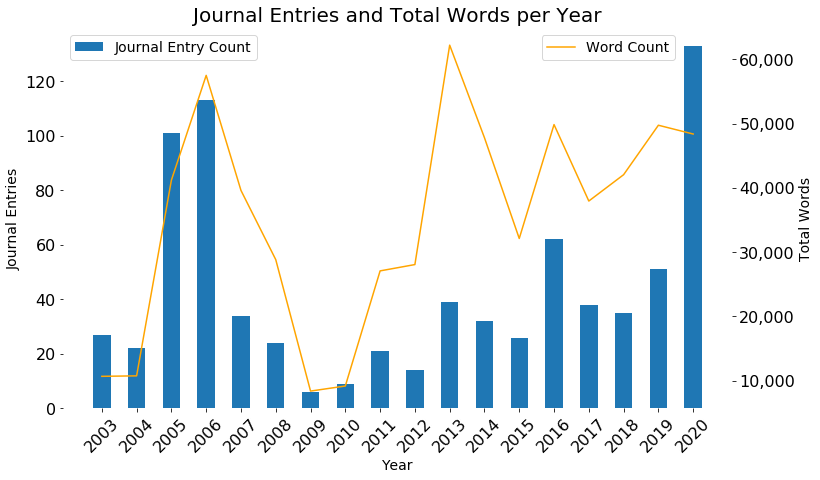

In [5]:
import matplotlib as mpl

fig, axes = plt.subplots(figsize=(12,7))
ax = entries_per_year.plot(kind='bar')
ax.set_title("Journal Entries and Total Words per Year", fontsize=20)
ax2 = words_per_year.plot(secondary_y=True, ax=ax, fontsize=16, color='orange')
ax.set_xlabel('Year', fontsize=14)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Journal Entries', fontsize=14)
ax2.set_ylabel('Total Words', fontsize=14)
ax.legend(["Journal Entry Count"], loc='best', prop={"size":14})
ax2.legend(["Word Count"], bbox_to_anchor=(.925, 1.00), prop={"size":14})

#iterate through axes, to do basic formating
for i, ax in enumerate(fig.axes):
    #add comma
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    #remove spines
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    ax.xlabel = "Year"
ax.autoscale(tight=False)

Journal output spiked dramatically around 2005/2006 which happened to be a year of transition for me - finishing up college, getting a job, and moving to San Francisco. Clearly, there were more things to analyze, plan, ruminate about, and organize in my journal during this time.

Additional spikes in word count are in 2013 (traveling for a year, transitioning to a new job) and 2016 (moving to Spain). In 2020, a new daily journal format was adopted,(5 minutes of writing every morning- inspired by Penn's method),  which is reflected in the drastically higher number of entries and total words.

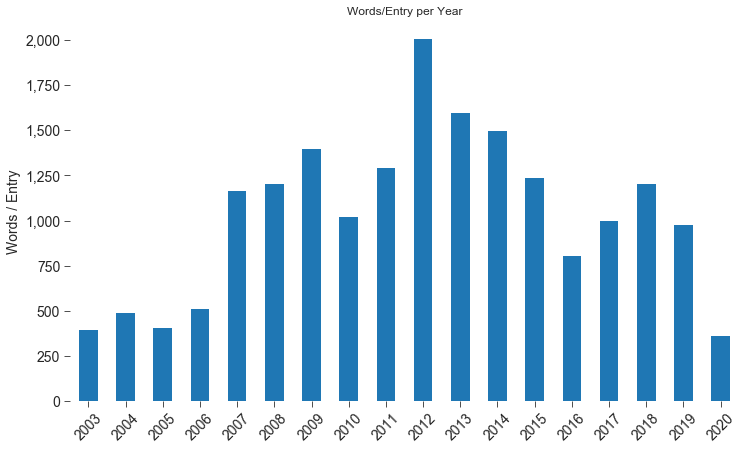

In [6]:
style.use('seaborn-ticks')
fig, axes = plt.subplots(figsize=(12,7))

ax = words_entry_year.plot(kind='bar', fontsize=14, title ="Words/Entry per Year")
ax.set_xlabel('')
ax.set_ylabel('Words / Entry', fontsize=14)
ax.tick_params(axis='x', rotation=45)

#iterate through axes, to do basic formating
for i, ax in enumerate(fig.axes):
    #add comma
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    #remove spines
    for key, spine in ax.spines.items():
        spine.set_visible(False)

From 2003 to 2006, words / journal entry remained constant. In 2007 and 2012, words/entry increased dramatically - indicating deeper analysis, ruminations, and pros/cons lists about important decisions during this time.  The year 2020 indicates the new format of daily 5 minute journals resulting in a sharp decrease in words/entry.

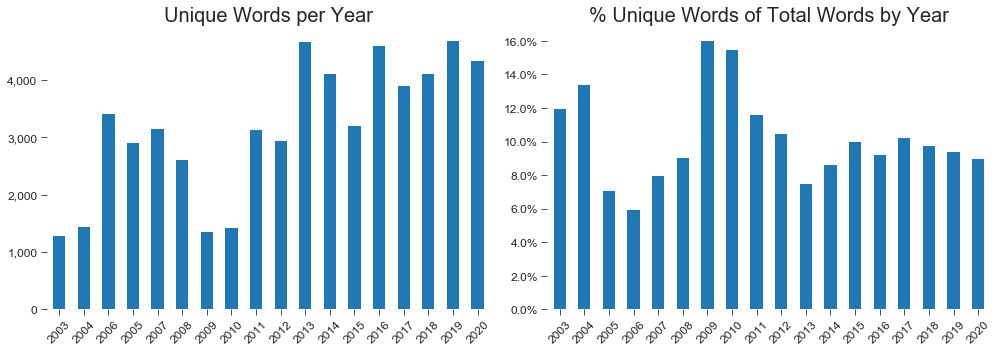

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
unique_word_year.plot(kind='bar',fontsize=12, ax=axes[0])
axes[0].set_title('Unique Words per Year', fontsize=20)
uniques_per_total_words.plot(kind='bar', fontsize=12, ax=axes[1])
axes[1].set_title('% Unique Words of Total Words by Year', fontsize=20)

#iterate through axes, to do basic formating
for i, ax in enumerate(fig.axes):
    #add comma
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    #remove spines
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)
axes[1].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))
fig.tight_layout()

The data show a general upward trend of unique word usage as time goes on. This could indicate an increase in vocabulary as well as a wider variety of experiences to write about.

The figure on the right shows % unique words of total words, calculated by summing unique words and dividing by total words. It's essentially a statistic of word repetition - it generally remains constant with notable spikes in 2003/4 and 2009/2010. Further analysis will be needed to dig into these spikes.

Let's look at seasonality next - are there dips in the frequency of journey entries by month? Perhaps journaling is more common in January - due to increased focus on reflection and resolutions.

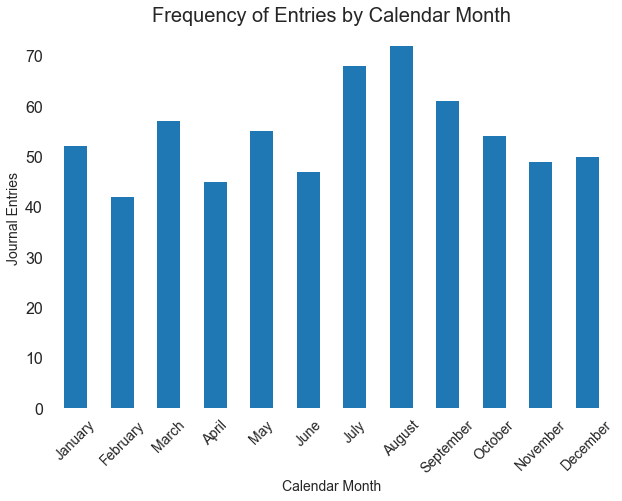

In [8]:
import datetime

#Convert to calendar month
def convert_to_month_name(monthinteger):
    #pdb.set_trace()
    monthinteger = int(monthinteger)
    return(datetime.date(1900, monthinteger, 1).strftime('%B'))

#Exclude 2020 - incomplete year
year_mask = journal_df['year']!='2020'
journal_df_pre_2000 = journal_df[year_mask]

frequency_by_month = journal_df_pre_2000.groupby(journal_df_pre_2000['datetime'].dt.month)['entry'].count()
frequency_by_month = pd.DataFrame(frequency_by_month).reset_index()
frequency_by_month['Month'] = frequency_by_month['datetime'].apply(convert_to_month_name)
frequency_by_month['Month'] = frequency_by_month['datetime'].apply(convert_to_month_name)
frequency_by_month = frequency_by_month.set_index('Month')['entry']

chart = frequency_by_month.plot(kind='bar', figsize=(10, 7), fontsize=16)
plt.title("Frequency of Entries by Calendar Month", fontsize=20)
chart.set_xlabel("Calendar Month", fontsize=14)
chart.set_ylabel("Journal Entries", fontsize=14)
chart.tick_params(axis='x', rotation=45)
chart.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in chart.spines.items():
    spine.set_visible(False)
     
plt.xticks(fontsize=14)
plt.grid(False)
plt.show(chart)

Frequency of Journal entries by month is relatively constant, with small peaks in the summer months (July/August).  Possibly there was more vacation/traveling during these times, therefore more new experiences to write about. 

# Most Common Words

The first step is to get a general view of the most common words.  We will use the lemmatized version in order to simplify our visualization (went, go, going should all be considered as the verb 'go).

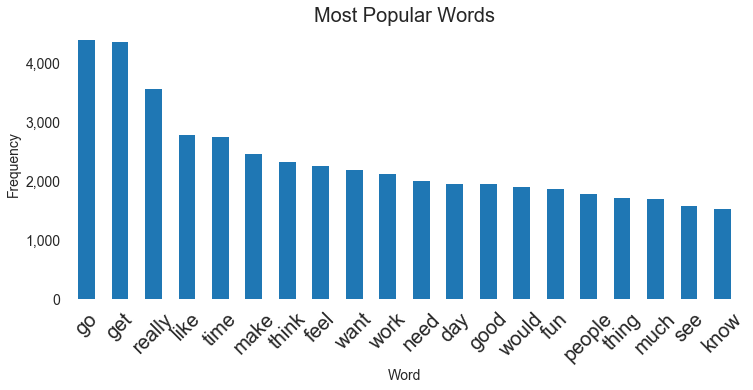

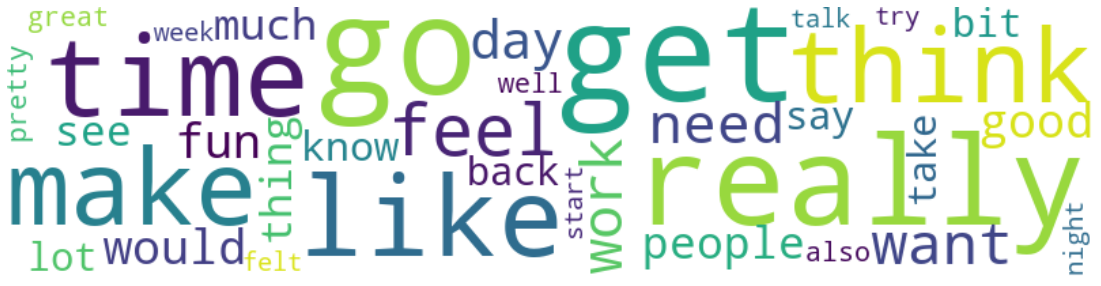

In [9]:
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud


#filter out stop words
stop_words = stopwords.words('english')
#Exclude puntuation
punc = string.punctuation
for thing in punc:
    stop_words.append(thing)
stop_words.append('’')
stop_words.append('”')
stop_words.append('“')

#itterate through lemmatized words, create word_list and frequency distribution
word_list =[]
for i, row in journal_df.iterrows():
    for word in row['lemmatized_words']:
        if word not in stop_words:
            word_list.append(word)
fdist = FreqDist(word_list)

#convert fdist to DF
df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'
df_fdist.sort_values('Frequency', ascending=False, inplace=True)

#Visualize
chart = df_fdist.head(20).plot(kind='bar', fontsize=14, figsize=(12, 5))
plt.title("Most Popular Words", fontsize=20)
chart.set_xlabel("Word", fontsize=14)
chart.set_ylabel("Frequency", fontsize=14)
chart.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)
plt.xticks(fontsize=20)
chart.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
chart.tick_params(axis='x', rotation=45 )
chart.get_legend().remove()
plt.show(chart)

#Create word cloud
wordcloud = WordCloud(max_words=35, max_font_size=100, width=800, height=200, margin=0, background_color = "white")
wordcloud.generate_from_frequencies(frequencies=df_fdist['Frequency'].to_dict())
plt.figure(figsize=(20,5), )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

fig.tight_layout()

Top words make sense - holds to logic that they would be used frequently in a journal.

# Parts of Speech and Sentiment

Let's dive a bit deeper into top words and categorize them by the part of speech (verb, noun, proper noun, adjective, adverb).

In [10]:
import nltk
import textblob

stop_words=set(stopwords.words("english"))
pos_list_of_dicts = []

for i, row in journal_df.iterrows():
    paragraph_index = 0
    for paragraph in row['sentences_tokenized']:
        sentence_index = 0
        for sentence in paragraph:
            #remove contractions
            sentence_no_contractions = contractions.fix(sentence)
            #remove puntuation
            sentence_no_contractions = re.sub(r'[^\w\s]','',sentence_no_contractions)
            tokenized_sentence = nltk.word_tokenize(sentence_no_contractions)
            part_of_speech_phrase = nltk.pos_tag(tokenized_sentence)
            
            sentiment = TextBlob(sentence).sentiment
            polarity = sentiment[0]
            subjectivity = sentiment[1]
            lemmatized_word_list = lemmatize_with_postag(sentence_no_contractions)
            d={}
            d['sentence'] = sentence_no_contractions
            d['year']= row.year
            d['subjectivity'] = subjectivity
            d['polarity'] = polarity

            for word, lemmatized_word in zip(part_of_speech_phrase, lemmatized_word_list):
            #for word in part_of_speech_phrase:
                if word[0] not in stop_words and word[0].isalpha():
                    
                    pos_list_of_dicts.append({'word': str.lower(word[0]), 'pos': word[1], 
                                              'row_index' : i, 'paragraph_index' : paragraph_index, 
                                              'sentence_index' : sentence_index,
                                             'sentence' : sentence, 'year' : row.year,
                                             'subjectivity' : subjectivity, 'polarity' : polarity, 'lemmatized_word' : lemmatized_word})

            sentence_index += 1
        paragraph_index += 1    
pos_DF = pd.DataFrame(pos_list_of_dicts)

In [11]:
#Add mapping to pos_DF to indicate general word type
pos_lookup = {
    'NN':'noun', #	noun, singular (cat, tree)
    'NNS':'noun',#	noun plural (desks)
    'NNP':'noun',#	proper noun, singular (sarah)
    'NNPS':'noun', #proper noun, plural (indians or americans)]
    'POS' : 'noun', # possessive ending parent's'
    
    'VB': 'verb',#	verb (ask)
    'VBG': 'verb',#	verb gerund (judging)
    'VBD': 'verb',#	verb past tense (pleaded)
    'VBN': 'verb',#	verb past participle (reunified)
    'VBP': 'verb',#	verb: 'verb', present tense not 3rd person singular(wrap)
    'VBZ': 'verb', #'verb', present tense with 3rd person singular (bases)
    'MD' : 'verb', #modal could, will
    
    'JJ':'adjective',#	adjective (large)
    'JJR':'adjective',#	adjective, comparative (larger)
    'JJS':'adjective',#	adjective, superlative (largest)
    
    'FW':'foreign_word',
    
    'RB':'adverb',#	adverb (occasionally, swiftly)
    'RBR':'adverb',#	adverb, comparative (greater)
    'RBS':'adverb',#	adverb, superlative (biggest)
    
    'NNP':'proper_noun',#	proper noun, singular (sarah)
    'NNPS':'proper_noun',
    'PRP': 'proper_noun', #personal pronoun', I, he, she
    'PRP$': 'proper_noun' # possessive pronoun my, his, hers
}
pos_DF['pos_general'] = pos_DF['pos'].map(pos_lookup)

#aggregate part of speech by pos_general for easy visualization
cleaned_df = pd.DataFrame(pos_DF.groupby(['pos', 'lemmatized_word'])['pos'].count()).rename(columns={'pos':'count'}).reset_index()

nouns=[
'NN',#	noun, singular (cat, tree)
'NNS',#	noun plural (desks)
'NNP',#	proper noun, singular (sarah)
'NNPS',#proper noun, plural (indians or americans)
'POS'
]
nouns_mask = cleaned_df.pos.isin(nouns)
top_nouns = cleaned_df[nouns_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)

verbs=[
'VB',#	verb (ask)
'VBG',#	verb gerund (judging)
'VBD',#	verb past tense (pleaded)
'VBN',#	verb past participle (reunified)
'VBP',#	verb, present tense not 3rd person singular(wrap)
'VBZ',#	verb, present tense with 3rd person singular (bases)
'MD']
verbs_mask = cleaned_df.pos.isin(verbs)
top_verbs = cleaned_df[verbs_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)
top_verbs.head(40)


adjectives=[
    'JJ',#	adjective (large)
    'JJR',#	adjective, comparative (larger)
    'JJS'#	adjective, superlative (largest)
]
adjectives_mask = cleaned_df.pos.isin(adjectives)
top_adjectives = cleaned_df[adjectives_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)
top_adjectives.head(40)

foreign_word=[
    'FW'
]
FW_mask = cleaned_df.pos.isin(foreign_word)
top_FW = cleaned_df[FW_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)
top_FW.head(40)

adverbs = [
'RB',#	adverb (occasionally, swiftly)
'RBR',#	adverb, comparative (greater)
'RBS',#	adverb, superlative (biggest)
]

adverbs_mask = cleaned_df.pos.isin(adverbs)
top_adverbs = cleaned_df[adverbs_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)
top_adverbs.head(40)

proper_nouns=[
'NNP',#	proper noun, singular (sarah)
'NNPS',#proper noun, plural (indians or americans)
#'PRP',
'PRP$'
]
proper_nouns_mask = cleaned_df.pos.isin(proper_nouns)
top_proper_nouns = cleaned_df[proper_nouns_mask].groupby('lemmatized_word').sum().sort_values('count', ascending=False)

#combine everything
top_nouns['type'] = 'noun'
top_verbs['type'] = 'verb'
top_adjectives['type'] = 'adjective'
top_adverbs['type'] = 'adverbs'
top_proper_nouns['type'] = 'proper_noun'

top_words_pos = pd.concat([top_nouns, top_verbs, top_adjectives, top_adverbs, top_proper_nouns])

NOUNS:


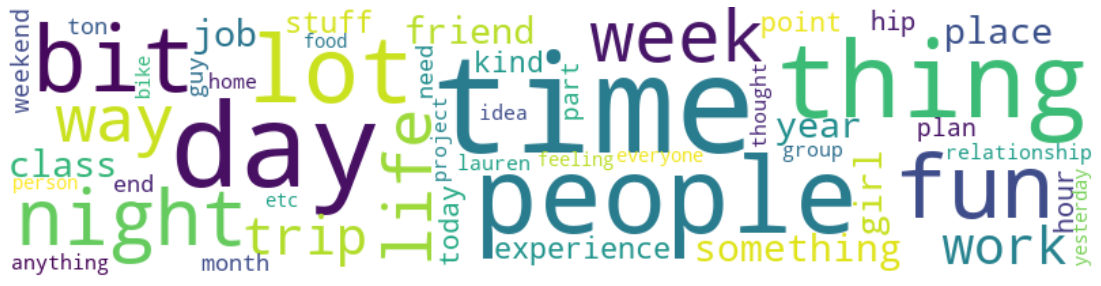

In [12]:
print('NOUNS:')
wordcloud = WordCloud(max_words=50, max_font_size=100, width=800, height=200, margin=0, background_color = "white")
wordcloud.generate_from_frequencies(frequencies=top_nouns['count'].to_dict())
plt.figure(figsize=(20,5), )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The wordcloud gives an interesting perspective into what is important in my life: people, time and fun!

VERBS:


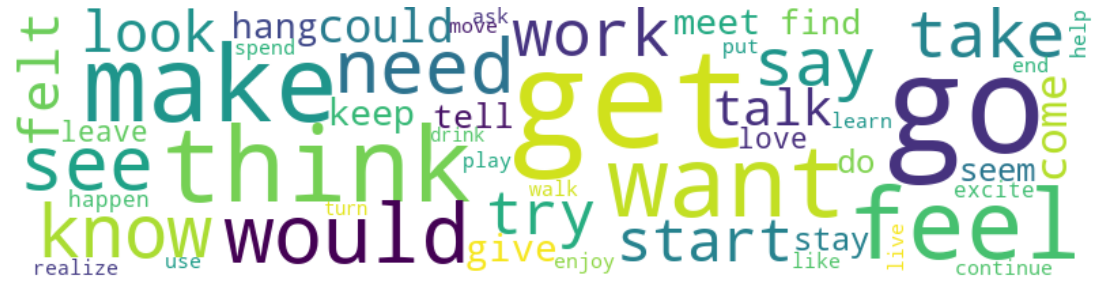

In [13]:
censor_mask = top_verbs.index!='fuck'
print('VERBS:')
wordcloud = WordCloud(max_words=50, max_font_size=100, width=800, height=200, margin=0, background_color = "white")
#wordcloud.generate_from_frequencies(frequencies=top_verbs['count'].to_dict())
wordcloud.generate_from_frequencies(frequencies=top_verbs[censor_mask]['count'].to_dict())
plt.figure(figsize=(20,5), )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Verbs of introspection: think, want, feel, know, need, know. 

ADJECTIVES:


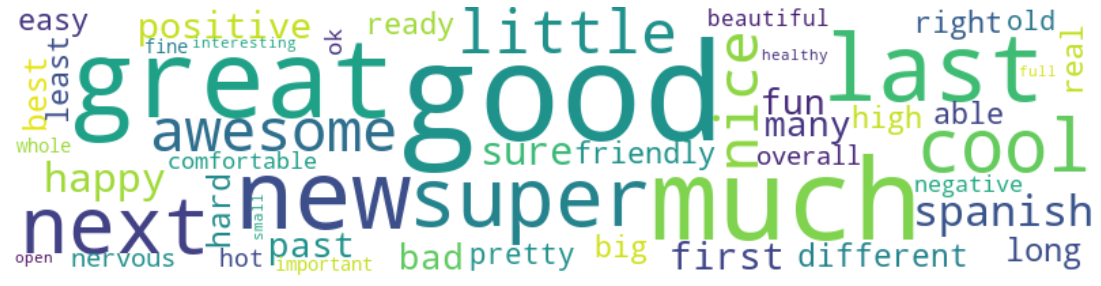

ADVERBS:


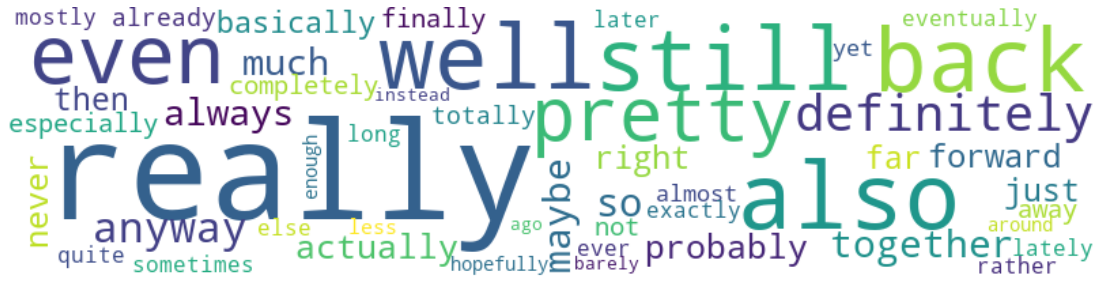

In [14]:
censor_mask = top_adjectives.index!='fucking'
print('ADJECTIVES:')
wordcloud = WordCloud(max_words=50, max_font_size=100, width=800, height=200, margin=0, background_color = "white")
wordcloud.generate_from_frequencies(frequencies=top_adjectives[censor_mask]['count'].to_dict())
plt.figure(figsize=(20,5), )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

print('ADVERBS:')
wordcloud = WordCloud(max_words=50, max_font_size=100, width=800, height=200, margin=0, background_color = "white")
wordcloud.generate_from_frequencies(frequencies=top_adverbs['count'].to_dict())
plt.figure(figsize=(20,5), )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Mostly positive adjectives and adverbs: good, great, awesome, super, nice.  I think this reflects my generally positive nature!

# Most common n-grams

N-grams are defined as "a contiguous sequence of n items from a given sample of text or speech."  Essentially, it is a series of N continuous words in a text.  Let's do some basic n-gram analysis on the journal to see if any interesting patterns emerge.  

Read more here: https://en.wikipedia.org/wiki/N-gram

In [15]:
from nltk import ngrams
import pdb

def n_grams_function(journal_df, n=2):
    grams_list = []
    for i, row in journal_df.iterrows():
        for paragraph in row['sentences_tokenized']:
            for sentence in paragraph:
                sentence = re.sub(r'[^\w\s]','',sentence)
                tokenized_sentence = nltk.word_tokenize(str.lower(sentence))
                grammed_sentence = ngrams(tokenized_sentence, n)
                for gram in grammed_sentence:
                    grams_list.append(gram)
    grams_df = pd.DataFrame(grams_list)
    n_gram_combined_list=[]
    test = pd.DataFrame(grams_list)
    for i, row in test.iterrows():
        n_gram = ''
        for word_position in range(0,n):
            word = row.iloc[word_position]
            n_gram = n_gram + ' ' + word
        n_gram_combined_list.append(n_gram)   
    return pd.DataFrame(n_gram_combined_list)  

In [17]:
two_grams_df_with_function = n_grams_function(journal_df, n=2)
three_grams_df_with_function = n_grams_function(journal_df, n=3)
four_grams_df_with_function = n_grams_function(journal_df, n=4)
five_grams_df_with_function = n_grams_function(journal_df, n=5)




two_grams_for_plot = two_grams_df_with_function[0].value_counts()[:10]
three_grams_for_plot = three_grams_df_with_function[0].value_counts()[:10]
four_grams_for_plot = four_grams_df_with_function[0].value_counts()[:10]
five_grams_for_plot = five_grams_df_with_function[0].value_counts()[:10]

two_grams_for_plot = two_grams_df_with_function[0].value_counts()[:5]
three_grams_for_plot = three_grams_df_with_function[0].value_counts()[:5]
four_grams_for_plot = four_grams_df_with_function[0].value_counts()[:5]
five_grams_for_plot = five_grams_df_with_function[0].value_counts()[2:7]


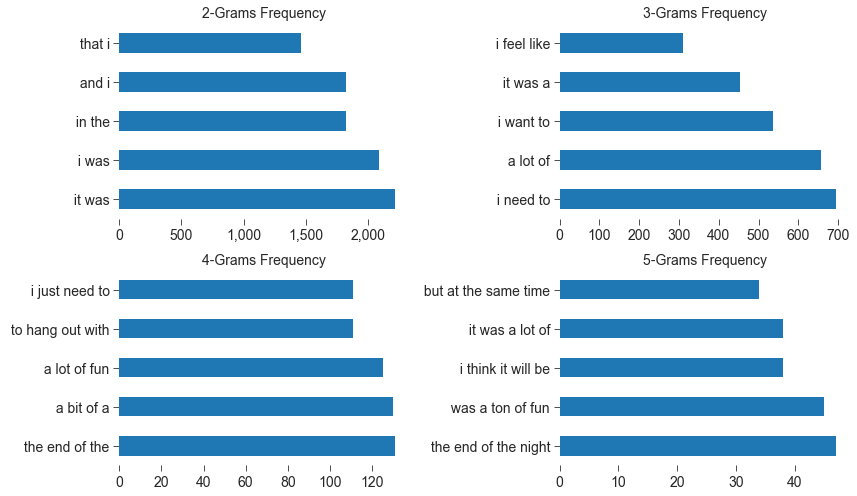

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,7))
two_grams_for_plot.plot(kind='barh',title='2-Grams Frequency', fontsize=14, ax=axes[0,0])
three_grams_for_plot.plot(kind='barh',title='3-Grams Frequency', fontsize=14, ax=axes[0,1])
four_grams_for_plot.plot(kind='barh',title='4-Grams Frequency', fontsize=14, ax=axes[1,0])
five_grams_for_plot.plot(kind='barh',title='5-Grams Frequency', fontsize=14, ax=axes[1,1])

#unique_word_year.plot(kind='bar',fontsize=12, ax=axes[0])
# axes[0].set_title('Unique Words per Year', fontsize=20)
# uniques_per_total_words.plot(kind='bar', fontsize=12, ax=axes[1])
# axes[1].set_title('% Unique Words of Total Words by Year', fontsize=20)

#iterate through axes, to do basic formating
for i, ax in enumerate(fig.axes):
    ax.title.set_size(14)
    #add comma
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    #remove spines
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_xlabel('')
fig.tight_layout()

* 3-Grams.  Starting to get interesting.  Phrases like "I need to" and "I want to" reveal recurring thoughts, desires and plans.  It would be interesting to dig into these bigrams further - what are common words that come after them?
* 4-Grams. Plenty of additional roads to investigate.  For example, I mention 'a lot of fun' over 100 times - what is a lot of fun?  What are the common nouns that are associated with this 4-gram?
* 5-Grams. Interesting to see that 'but at the same time' was written over 40 times - it's presence indicates a contrast of sorts - perhabs a positive and negative thought in the same sentence?  It's a perfect example of how messy it is to analyze text: oftentimes, a single sentence or phrase cannot be easily classified as 100% positive or negative.  

# Sentiment Analysis

Sentiment analysis is an NLP technique to quantify the emotional state of a text. It leverages machine learning principles and a common methodology is to classify the text as positive or negative. Textblob provides a 'polarity score' of sentiment, which is afloat within the range [-1.0, 1.0] - negative values indicate negative sentiment and positive indicate positive sentiment. 

The default method for Textblob's sentiment score uses a Sentiment Polarity Lexicon, (based on the pattern library), which is essentially a dictionary of words and their corresponding polarity and subjectivity values. Textblob also has an option for using a Naive Bayes Analyzer (an NLKT classifier trained on movie reviews). Additionally, it allows for using your own test data to train a custom Naive Bayes classifier. We'll save the classifier methods for use in a future project - for now, let's dig into the default method of calculating polarity. 

Let's start off by calculating the polarity of each journal entry and sentence.

In [21]:
#by entry
sentiment_list = []
for i, row in journal_df.iterrows():
    #join all paragraphs into single string
    journal_entry_string = ' '.join(row['entry'])
    sentiment = TextBlob(journal_entry_string).sentiment
    polarity = sentiment[0]
    subjectivity = sentiment[1]
    d={}
    d['entry'] = journal_entry_string
    d['year']= row.year
    d['subjectivity'] = subjectivity
    d['polarity'] = polarity
    d['index'] = i
    d['datetime'] = row.datetime
    sentiment_list.append(d)
sentiment_by_entry_df = pd.DataFrame(sentiment_list)
#add calendar month column
sentiment_by_entry_df['month_integer'] = sentiment_by_entry_df['datetime'].dt.month
sentiment_by_entry_df['month_name'] = sentiment_by_entry_df['month_integer'].apply(convert_to_month_name)

#by sentence
sentiment_list = []
for i, row in journal_df.iterrows():
    for paragraph in row['sentences_tokenized']:
        for sentence in paragraph:
            sentiment = TextBlob(sentence).sentiment
            polarity = sentiment[0]
            subjectivity = sentiment[1]
            d={}
            d['sentence'] = sentence
            d['year']= row.year
            d['subjectivity'] = subjectivity
            d['polarity'] = polarity
            d['index'] = i
            d['datetime'] = row.datetime
            sentiment_list.append(d)
sentiment_by_sentence_df = pd.DataFrame(sentiment_list)

Some examples of the output - all seem pretty positive to me:

* Neither my hip nor knee hurt...was awesome!
* Man I just had the thought that I’m one of the best people at Excel in the office.
* We went to Morton’s and the food was delicious.
* Awesome group we have.
* It was awesome.
* For me, those are the best.
* It’s just the perfect atmosphere for it.

Apparently, 'awesome' is one of my favorite words and is a high predictor of positive polarity.

Some examples of the output that are clearly negative:

* I went to a musuem in the worst town ever (Lambayugua or something).
* I hate losing!
* I was in an awful mood.
* Then we went to this horrible breakfast at 7 am.

However, there were several sentences that were not necessarily negative, yet got classified as fully negative (-1.0):

* The nightlife here is insane - the bar didn’t close until 5AM!
* Wrote a script that wasn’t terrible and could use some work - I should keep iterating on it.

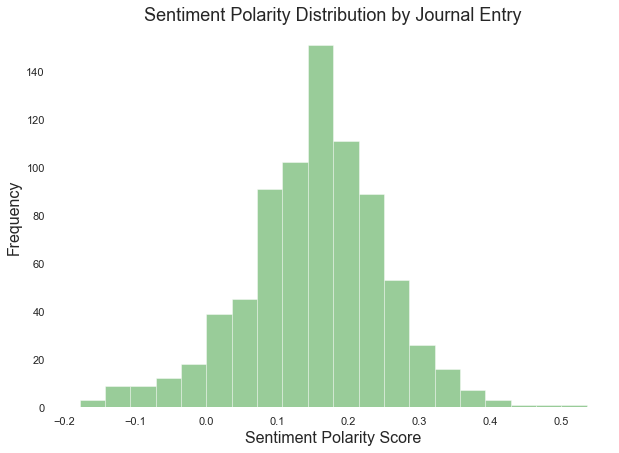

In [198]:
import seaborn as sns
plt.figure(figsize=(10,7))

chart = sns.distplot(sentiment_by_entry_df['polarity'], kde=False, color='green', bins=20)
plt.title('Sentiment Polarity Distribution by Journal Entry', fontsize=18)
plt.xlabel('Sentiment Polarity Score', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

sns.set(style="whitegrid")
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)


We see a rather normal distribution of sentiment polarity scores of journal entries - with the majority skewing slightly positive. 

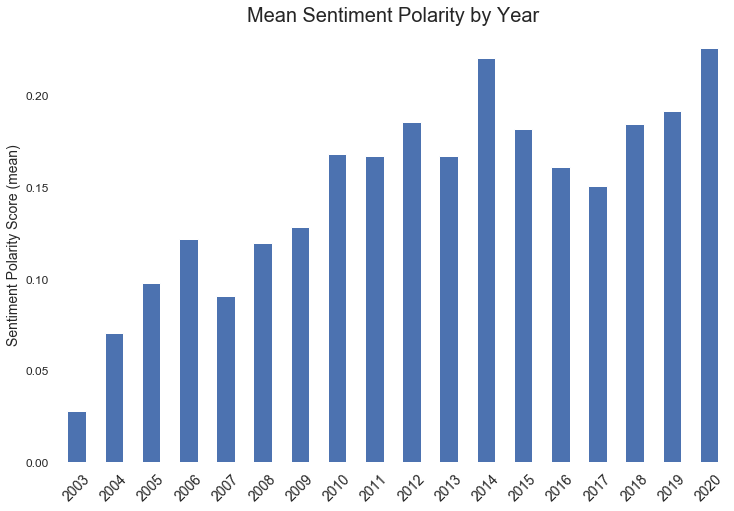

In [80]:
#ENTRY
mean_sentiment = sentiment_by_entry_df.groupby('year')['polarity'].agg(['mean'])

chart = mean_sentiment.plot(kind='bar', figsize=(12, 8), fontsize=12)
plt.title("Mean Sentiment Polarity by Year", fontsize=20)

chart.set_xlabel("", fontsize=14)
chart.tick_params(axis='x', rotation=45)
plt.xticks(fontsize=14)

chart.set_ylabel("Sentiment Polarity Score (mean)", fontsize=14)
chart.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in chart.spines.items():
    spine.set_visible(False)
    
chart.get_legend().remove()
plt.grid(False)
plt.show(chart)


The mean sentiment polarity has been steadily increasing year over year!  This is a good sign of a general upward trend in positivity of journal entries as time goes on.  

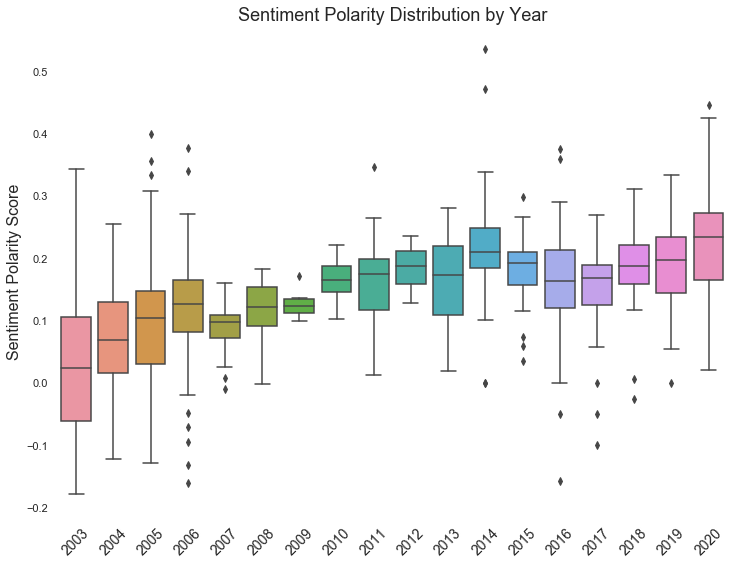

In [82]:
plt.figure(figsize=(12,9))
ax = sns.boxplot( y="polarity", x='year', data=sentiment_by_entry_df)
#ax.set_ylim([4,25])
plt.title('Sentiment Polarity Distribution by Year', fontsize=18)
#plt.xlabel('# of Ratings Group', fontsize=16)
plt.ylabel('Sentiment Polarity Score', fontsize=16)
plt.xlabel('')

ax.tick_params(axis='x', rotation=45)
plt.xticks(fontsize=14)

for key, spine in ax.spines.items():
    spine.set_visible(False)
plt.grid(False)

The box and whisker plot by year shows the variability of the sentiment polarity of each entry by year. We can see that 2003 was a highly volatile year; this makes sense as it was a time of transition as well as the start of keeping a journal.

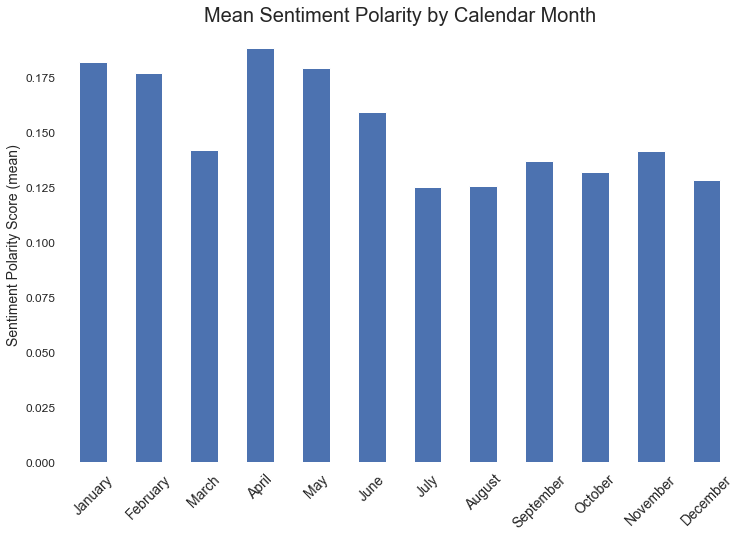

In [123]:
polarity_monthly_series = sentiment_by_entry_df.groupby(['month_integer', 'month_name'])['polarity'].mean().reset_index('month_integer')['polarity']

chart = polarity_monthly_series.plot(kind='bar', figsize=(12, 8), fontsize=12)
plt.title("Mean Sentiment Polarity by Calendar Month", fontsize=20)

chart.set_xlabel("", fontsize=14)
chart.tick_params(axis='x', rotation=45)
plt.xticks(fontsize=14)

chart.set_ylabel("Sentiment Polarity Score (mean)", fontsize=14)
chart.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in chart.spines.items():
    spine.set_visible(False)
    
plt.grid(False)
plt.show(chart)

We're seeing some very slight seasonality when viewing sentiment polarity by calendar month: slightly more positive sentiments at the start of the year, and moderately decreasing as the year comes to a close. This logically makes sense: January is the start of the year and a time for resolutions, new beginnings, and higher motivation to create change in one's life!

# Sentiment Polarity by Common Parts of Speech

Are certain words associated with more positive or negative sentences? Perhaps words like "work", "taxes" and "DMV" are generally more negative whereas words like "fun", "camping" and "vacation" are more positive. Can we uncover unknown trends in our choices, actions, and words using this technique?

In order to make this calculation, we are calculating the sentiment polarity at the sentence level and then simply tagging each word in that sentence with the polarity score of the entire sentence. It's a rough approximation to get a general idea of how words influence the overall sentiment of the sentence.

Let's create a quick function to easily graph different cuts of words by parts of speech (nouns, proper nouns, verbs, adjectives).

In [158]:
def get_polarity_by_top_x(reference_POS_df, POS_individual_df, part_of_speech_name, top_x):
    top_POS_list = POS_individual_df[:top_x].index.to_list()
    mask = reference_POS_df.lemmatized_word.isin(top_POS_list)
    polarity_summary = reference_POS_df[mask].groupby('lemmatized_word')['polarity'].mean().sort_values()
    plt.figure(figsize=(10,8))
    chart = sns.barplot(y=polarity_summary.index, x=polarity_summary.values, alpha=0.9, color='lightgreen')
    title = 'Mean Sentiment Polarity of Top ' + part_of_speech_name
    plt.title(title, fontsize=20)
    plt.ylabel(part_of_speech_name, fontsize=15)
    plt.xlabel('Sentiment Polarity', fontsize=15)
    ylabel = ' Top ' + part_of_speech_name
    plt.ylabel(ylabel, fontsize=15)

    plt.yticks(fontsize=18)
    
    plt.grid(False)
    for key, spine in chart.spines.items():
        spine.set_visible(False)

    plt.show()

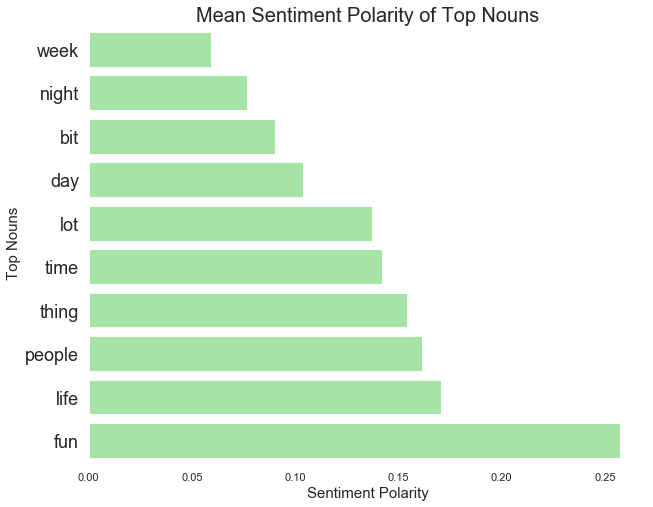

In [159]:
get_polarity_by_top_x(pos_DF, top_nouns, 'Nouns', 10)

This figure shows the mean sentiment polarity by the most common nouns.  The top 3 most positive nouns are 'people', 'life' and 'fun' - obvious things that are quite positive.  

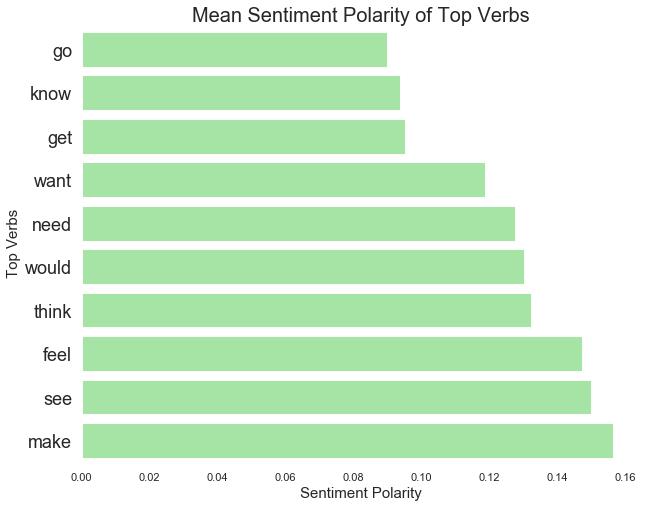

In [161]:
get_polarity_by_top_x(pos_DF, top_verbs, 'Verbs', 10)

Creating and experiencing verbs such as 'make', 'feel' and 'think' are some of the most positive common verbs.

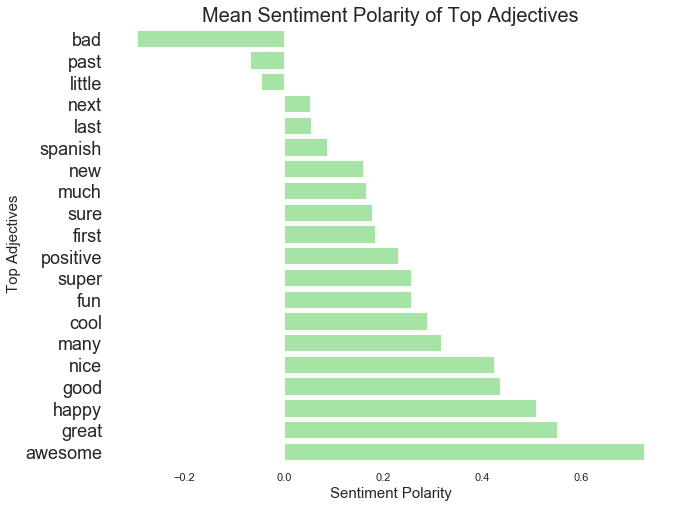

In [162]:
get_polarity_by_top_x(pos_DF, top_adjectives, 'Adjectives', 20)

The Textblob analyzer gives extra weight to the word 'awesome' - a personal favorite of mine.  On the opposite end of the spectrum, 'bad' is by far the most negative common adjective.  Makes sense.